<a href="https://colab.research.google.com/github/skyradez/Audio-based-Indonesia-Toxic-Language-Classification-using-RNN-Speech-Recognition-and-NLP/blob/main/RESEARCH_Audio_based_Indonesia_Toxic_Language_Classification_using_Recurrent_Neural_Network%2C_Speech_Recognition_and_Natural_Language_Processing_).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Audio-based Indonesia Toxic Language Classification using Recurrent Neural Network, Speech Recognition and Natural Language Processing.

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers
import time
import seaborn as sns
from matplotlib.pyplot import style

In [ ]:
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Load the CSV file into a DataFrame and split it into the "sentence" and "contains_bad_word" columns

In [ ]:
df = pd.read_csv('toxic(1).csv')
data = tf.data.Dataset.from_tensor_slices((df['sentence'].values, df['contains_bad_word'].values))

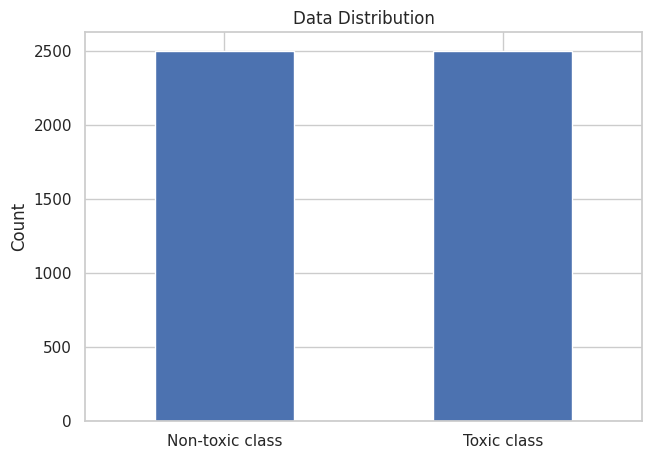

In [ ]:
df['contains_bad_word'].value_counts().plot(kind='bar')
plt.title('Data Distribution')
plt.xticks([0, 1], ['Non-toxic class', 'Toxic class'], rotation=0)
plt.ylabel('Count')
plt.show()

Convert the "contains_bad_word" column to a boolean type

In [ ]:
data = data.map(lambda sentence, contains_bad_word: (sentence, tf.cast(contains_bad_word, tf.bool)))

Shuffle and split the data into training, validation, and testing sets

In [ ]:
buffer_size = 10000
batch_size = 64
train_size = int(0.8 * len(df)) 
val_size = int(0.1 * len(df)) # 10% of data for validation
test_size = len(df) - train_size - val_size # remaining data for testing

train_data = data.take(train_size).shuffle(buffer_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_data = data.skip(train_size).take(val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_data = data.skip(train_size+val_size).batch(batch_size).prefetch(tf.data.AUTOTUNE) 

Create a TextVectorization layer to convert text to integers

In [ ]:
vocab_size = 1000
sequence_length = 100
vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size, output_mode='int', output_sequence_length=sequence_length)

Adapt the TextVectorization layer to the training data

In [ ]:
train_sentences = train_data.map(lambda sentence, contains_bad_word: sentence)
vectorize_layer.adapt(train_sentences)

Define the model

In [ ]:
model = tf.keras.Sequential([
    vectorize_layer,
    tf.keras.layers.Embedding(vocab_size, 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True,
                                                       kernel_regularizer=regularizers.l2(0.001),  # L2 regularization
                                                       recurrent_regularizer=regularizers.l2(0.001),
                                                       bias_regularizer=regularizers.l2(0.001))),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,
                                                       kernel_regularizer=regularizers.l2(0.001),  # L2 regularization
                                                       recurrent_regularizer=regularizers.l2(0.001),
                                                       bias_regularizer=regularizers.l2(0.001))),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # L2 regularization
    tf.keras.layers.Dropout(0.8),  # Dropout rate
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 100, 64)           64000     
                                                                 
 bidirectional_10 (Bidirecti  (None, 100, 128)         66048     
 onal)                                                           
                                                                 
 bidirectional_11 (Bidirecti  (None, 64)               41216     
 onal)                                                           
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                      

Compile the model

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

Train the model and evaluate its performance on both training and validation datasets

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=5, restore_best_weights=True)
history = model.fit(train_data, epochs=100, validation_data=val_data, callbacks=[early_stopping])

Epoch 1/100
63/63 [==============================] - 29s 208ms/step - loss: 1.5694 - accuracy: 0.7258 - val_loss: 0.8880 - val_accuracy: 0.9380
Epoch 2/100
63/63 [==============================] - 6s 88ms/step - loss: 0.7081 - accuracy: 0.9498 - val_loss: 0.5252 - val_accuracy: 0.9540
Epoch 3/100
63/63 [==============================] - 4s 62ms/step - loss: 0.4662 - accuracy: 0.9675 - val_loss: 0.4089 - val_accuracy: 0.9560
Epoch 4/100
63/63 [==============================] - 3s 43ms/step - loss: 0.3654 - accuracy: 0.9725 - val_loss: 0.3501 - val_accuracy: 0.9600
Epoch 5/100
63/63 [==============================] - 3s 49ms/step - loss: 0.3098 - accuracy: 0.9747 - val_loss: 0.3674 - val_accuracy: 0.9380
Epoch 6/100
63/63 [==============================] - 2s 35ms/step - loss: 0.2757 - accuracy: 0.9780 - val_loss: 0.3096 - val_accuracy: 0.9580
Epoch 7/100
63/63 [==============================] - 3s 40ms/step - loss: 0.2453 - accuracy: 0.9835 - val_loss: 0.2817 - val_accuracy: 0.9600
Epoc

Evaluate the model

In [ ]:
train_loss, train_acc = model.evaluate(train_data)
val_loss, val_acc = model.evaluate(val_data)
test_loss, test_acc = model.evaluate(test_data) 

print('Training Loss:', train_loss)
print('Training Accuracy:', train_acc)
print('Validation Loss:', val_loss)
print('Validation Accuracy:', val_acc)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

8/8 [==============================] - 0s 10ms/step - loss: 0.2657 - accuracy: 0.9520
Training Loss: 0.15698017179965973
Training Accuracy: 0.9894999861717224
Validation Loss: 0.25187304615974426
Validation Accuracy: 0.9639999866485596
Test Loss: 0.26569315791130066
Test Accuracy: 0.9520000219345093


Plot the accuracy and loss curves for both training and validation datasets

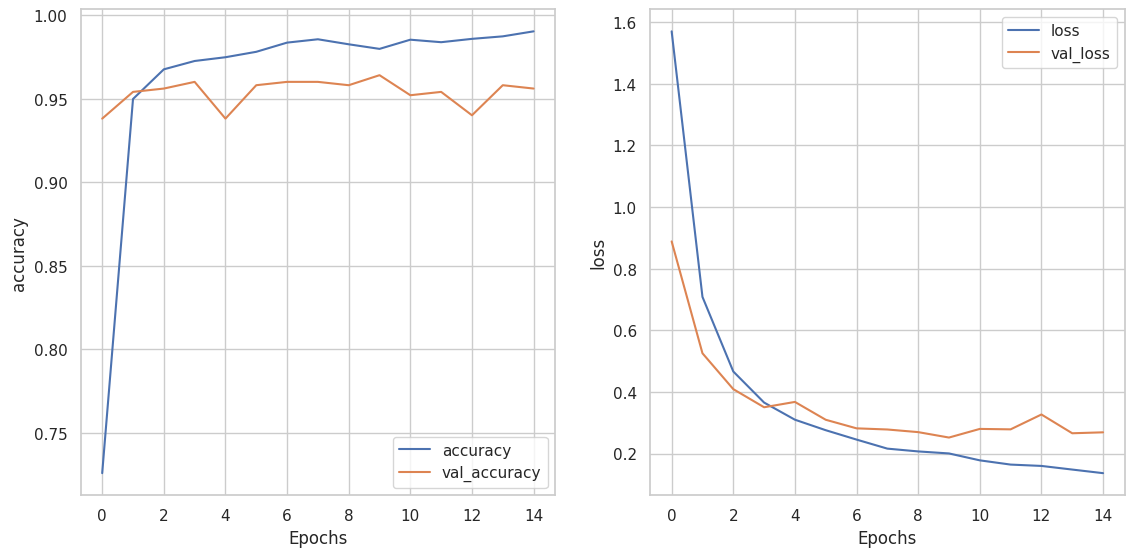

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.savefig('plot.png')
plt.show()

Evaluate the performance of a classification model by comparing its predicted values against the actual values

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

Get predictions for the test dataset

In [ ]:
y_test_true = []
y_test_pred = []

for sentences, labels in test_data: # use test_data
    predictions = model.predict(sentences)
    predictions = [1 if p >= 0.5 else 0 for p in predictions]
    y_test_pred.extend(predictions)
    y_test_true.extend(labels.numpy())

2/2 [==============================] - 5s 11ms/step


Calculate the F1 Score

In [ ]:
f1score = f1_score(y_test_true, y_test_pred)
print('F1-score:', f1score)

F1-score: 0.9482758620689654


In [ ]:
print("Unique values in validation labels:", np.unique(y_test_true))
print("Unique values in validation predictions:", np.unique(y_test_pred))

Unique values in validation labels: [False  True]
Unique values in validation predictions: [0 1]


Calculate the confusion matrix

In [ ]:
cm = confusion_matrix(y_test_true, y_test_pred)
tn, fp, fn, tp = cm.ravel()

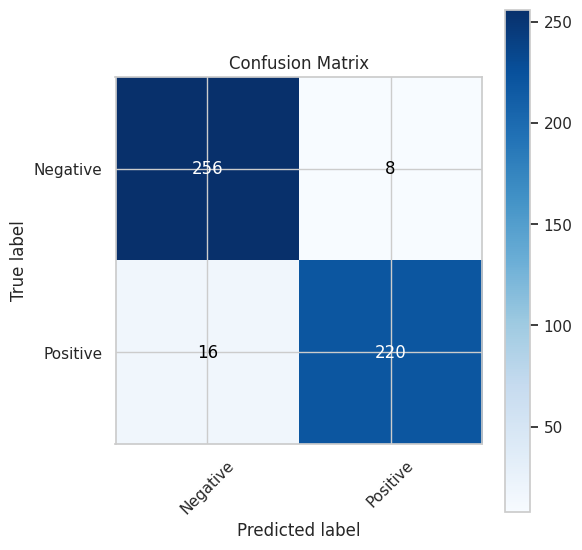

In [ ]:
# Assuming you already have the values for tn, fp, fn, tp
cm = np.array([[tn, fp], [fn, tp]])

# Define the labels for the classes
labels = ['Negative', 'Positive']

# Plotting the confusion matrix
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(labels))
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)

# Adding the values to the plot
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j]), ha='center', va='center',
             color='white' if cm[i, j] > thresh else 'black')

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

Calculate precision and recall

In [ ]:
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0

print('Precision:', precision)
print('Recall:', recall)

Precision: 0.9649122807017544
Recall: 0.9322033898305084


8/8 [==============================] - 8s 16ms/step


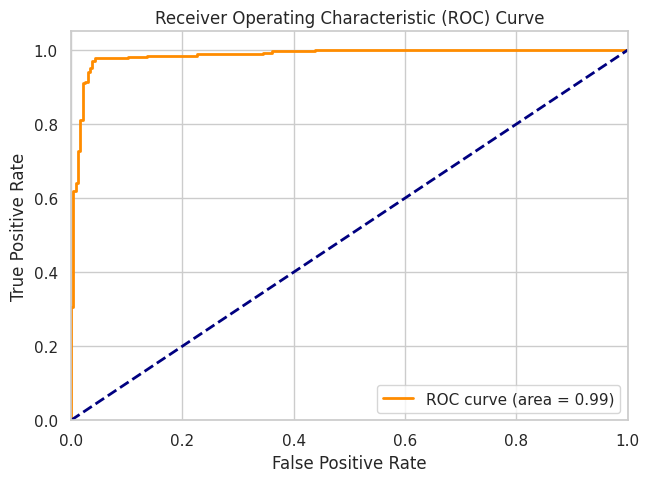

In [ ]:
from sklearn.metrics import roc_curve, auc

# Getting the probabilities of our predictions
y_scores = model.predict(val_data)
y_true = np.concatenate([y for x, y in val_data], axis=0)

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


Save the trained model to a file in the SavedModel format

In [ ]:
model.save('toxicity_detection_model', save_format='tf')

Load the saved model from file

In [ ]:
loaded_model = tf.keras.models.load_model('toxicity_detection_model')

Test the model on a new sentence (testing purpose only)

In [ ]:
# Toxicity prediction (true)
sample_sentence = 'pergi ke pasar beli kontol anjing mak lu'
prediction = loaded_model.predict(np.array([sample_sentence]))
print('Prediction:', prediction[0][0])

# Toxicity prediction (false)
sample_sentence = 'jalan bareng keluarga ketemu anjing dan kucing'
prediction = loaded_model.predict(np.array([sample_sentence]))
print('Prediction:', prediction[0][0])

# Toxicity prediction (true)
sample_sentence = 'anjing lu jadi orang ga jelas banget'
prediction = loaded_model.predict(np.array([sample_sentence]))
print('Prediction:', prediction[0][0])

1/1 [==============================] - 5s 5s/step
Prediction: 0.9593936
1/1 [==============================] - 0s 137ms/step
Prediction: 0.0060457974
1/1 [==============================] - 0s 52ms/step
Prediction: 0.994679


Install and import Speech Recognition library

In [ ]:
!pip install speechrecognition

import speech_recognition as sr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Initialize the speech recognizer

In [ ]:
r = sr.Recognizer()

Define a function to capture speech input and save it to a .txt file

In [ ]:
def capture_speech():
    with sr.Microphone() as source:
        print("Say something!")
        audio = r.listen(source)
    try:
        # use the speech recognizer to transcribe the audio to text
        text = r.recognize_google(audio, language="id-ID, en-US, zh-CN, zh-TW")
        # save the text to a .txt file
        with open('speech_input.txt', 'w') as f:
            f.write(text)
        return text
    except sr.UnknownValueError:
        print("Sorry, I didn't catch that.")
        return None

Import Tkinker library

In [ ]:
import tkinter as tk

In [ ]:
def get_prediction(sentence):
    prediction = loaded_model.predict(np.array([sentence]))
    return prediction[0][0]

# define a function to update the label with the prediction
def update_label():
    sentence = capture_speech()
    if sentence:
        prediction = get_prediction(sentence)
        result_label.config(text='Prediction: ' + str(prediction))
    time.sleep(1)

Create a Tkinter window and widgets

In [ ]:
8root = tk.Tk()
root.geometry('750x200')
root.title('Audio-based Toxic Language Classification using Speech Recognition and Natural Language Processing')

header_label = tk.Label(root, text='Push the button to start recording.', font=('Times New Roman', 11))
header_label2 = tk.Label(root,
                        text='The result will be a prediction ranging from 0 (no bad words detected) to 1 (bad words detected).',
                        font=('Times New Roman', 11))

header_label.pack(side='top', pady=3)
header_label2.pack(side='top', pady=8)

button_frame = tk.Frame(root)
button_frame.pack()

button = tk.Button(button_frame, text="Push to Talk", command=update_label, height=1, width=10, bg='red', fg='white', font=('Times New Roman', 11), anchor='center', justify='center', padx=10, pady=5)
button.pack(pady=5)

result_label = tk.Label(root, text='', font=('Times New Roman', 11))
result_label.pack(side='bottom', pady=10)

empty_frame = tk.Frame(root)
empty_frame.pack(side='top', fill='both', expand=True)

# start the main event loop
root.mainloop()

SyntaxError: ignored

The TclError occurs because Colab runs on a server that doesn't have a display, so it's not possible to create GUI windows using tkinter.

To resolve this issue, you can use a different library for the user interface that doesn't rely on a graphical interface, such as ipywidgets or streamlit.